### 1.import libraries

In [16]:
# import the libraries that we will use
import os
import numpy as  np
import pandas as pd
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize

# import the tdt library
import tdt

In [17]:
# get help on the function tdt.read_block()
tdt.read_block?

### 2.import data

In [18]:
block_path = 'D:/DataAtCSBD/FiberPhotometry/240320/CHD8_710M_HT'
block_path

'D:/DataAtCSBD/FiberPhotometry/240320/CHD8_710M_HT'

In [19]:
FPdata = tdt.read_block(block_path)
FPdata

Found Synapse note file: D:/DataAtCSBD/FiberPhotometry/240320/CHD8_710M_HT\Notes.txt
read from t=0s to t=968.32s


epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])

### 3.browse data 

위의 한 줄 코드로 block 내의 모든 데이터 반입. 반입된 data는 structured object(dictionary type in Python)임.</br>
데이터 크기가 커서 그 중 일부만 반입하는 것도 가능. 자세한 내용은 도움말 참고. </br>
tdt.read_block(PATH_BLOCK).info 명령어로 data에 대한 자세한 정보 확인 가능. 

In [20]:
FPdata.info

tankpath:	'D:\\DataAtCSBD\\FiberPhotometry\\240320'
blockname:	'CHD8_710M_HT'
start_date:	datetime.datetime(2024, 3, 20, 14, 35, 44, 999999)
utc_start_time:	'14:35:44'
stop_date:	datetime.datetime(2024, 3, 20, 14, 51, 53, 317559)
utc_stop_time:	'14:51:53'
duration:	datetime.timedelta(seconds=968, microseconds=317560)
stream_channel:	0
snip_channel:	0
experiment:	'YHG-setting-230404'
subject:	'mouse'
user:	'User'
start:	'2:35:46오후 03/20/2024'
stop:	'2:51:54오후 03/20/2024'

Streams 데이터에 접근

In [21]:
# export isosbestic and GCaMP signals
control_raw = FPdata.streams['_405A'].data
signal_raw = FPdata.streams['_465A'].data
control_raw, signal_raw

(array([ 0.63813287,  0.6369007 ,  0.63504386, ..., 42.475063  ,
        42.489426  , 42.50306   ], dtype=float32),
 array([ 0.20206504,  0.19427988,  0.186067  , ..., 63.591595  ,
        63.586315  , 63.58143   ], dtype=float32))

In [22]:
#control sample 수 확인
num_sample = len(control_raw)
num_sample

984832

In [23]:
#control sampling rate 확인
sampling_rate = FPdata.streams['_405A'].fs
sampling_rate

1017.2526245117188

In [24]:
# X-axis 생성
time_seconds = np.linspace(1, num_sample, num_sample)/sampling_rate
time_seconds

array([9.83039980e-04, 1.96607996e-03, 2.94911994e-03, ...,
       9.68127264e+02, 9.68128247e+02, 9.68129230e+02])

In [25]:
time_seconds_1 = time_seconds[np.min(np.where(time_seconds >= 1.0)):]
control_raw_1 = control_raw[np.min(np.where(time_seconds >= 1.0)):]
signal_raw_1 = signal_raw[np.min(np.where(time_seconds >= 1.0)):]

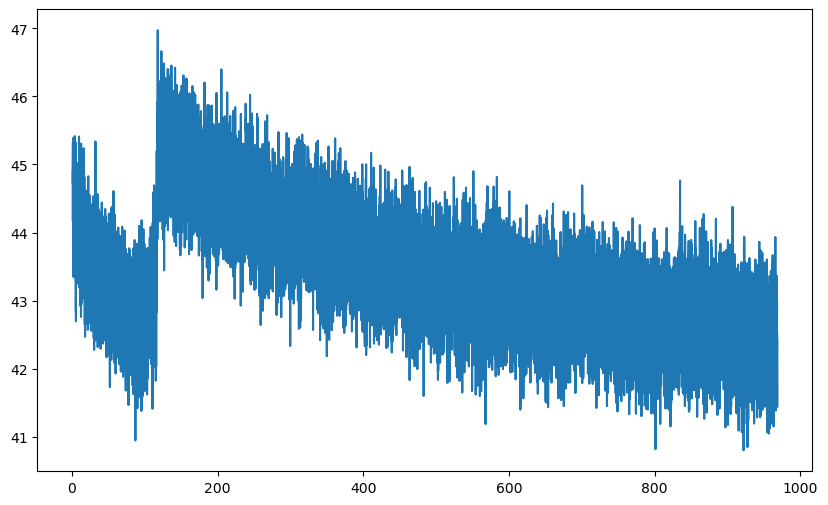

In [26]:
fig_405A = plt.subplots(figsize=(10,6))
plt.plot(time_seconds_1, control_raw_1)
plt.show()

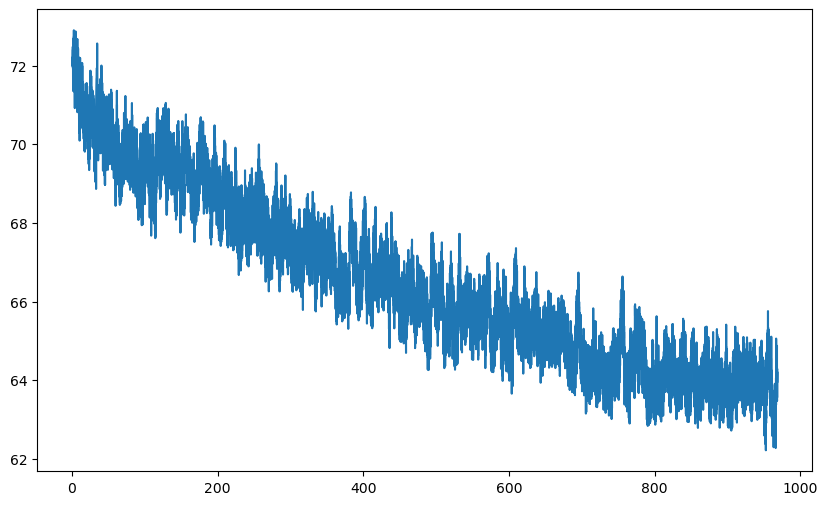

In [27]:
fig_465A = plt.subplots(figsize=(10,6))
plt.plot(time_seconds_1, signal_raw_1)
plt.show()

## Raw signals

Let's take a look at the raw GCaMP and isosbestic control signals.

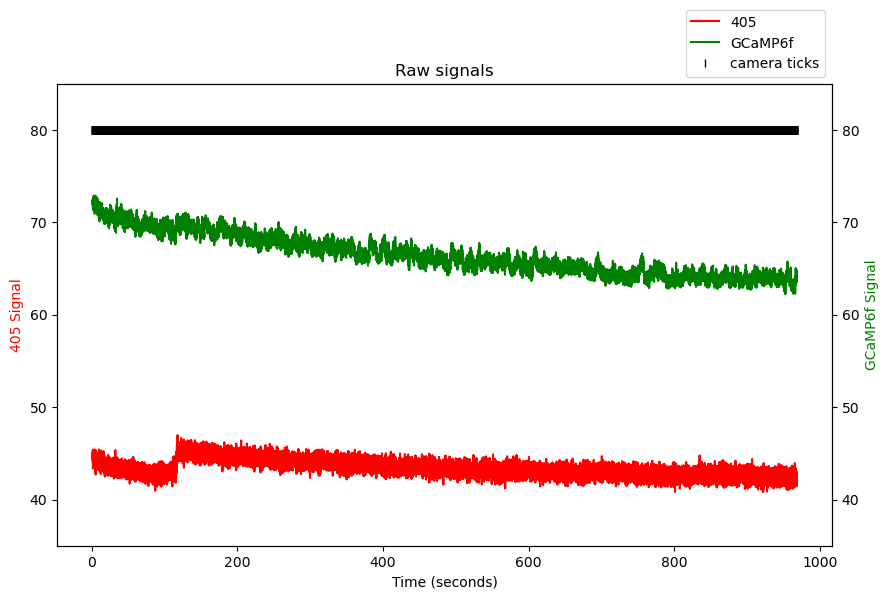

In [28]:
# plot signals
fig,ax1=plt.subplots(figsize=(10,6))  # create a plot to allow for dual y-axes plotting
plot1=ax1.plot(time_seconds_1, control_raw_1, 'r', label='405') #plot 405 on left y-axis
ax2=plt.twinx()# create a right y-axis, sharing x-axis on the same plot
plot2=ax2.plot(time_seconds_1, signal_raw_1, 'g', label='GCaMP6f') # plot GCaMP on right y-axis

# Plot rewards times as ticks.
camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 80), label='camera ticks', color='w', marker="|", mec='k')


ax1.set_ylim(35, 85)
# ax1.set_xlim(5, 10) # 초단위로 입력하여 x-axis zoom in 가능 
ax2.set_ylim(35, 85)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('405 Signal', color='r')
ax2.set_ylabel('GCaMP6f Signal', color='g')
ax1.set_title('Raw signals')

lines = plot1 + plot2 +camera_ticks #line handle for legend
labels = [l.get_label() for l in lines]  #get legend labels
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 1)) #add legend

In [29]:
FPdata.epocs.Cam1

name:	'Cam1'
onset:	array([5.70982400e-01, 6.14891520e-01, 6.61585920e-01, ...,
       9.68128430e+02, 9.68167588e+02, 9.68217559e+02])
offset:	array([6.14891520e-01, 6.61585920e-01, 7.14342400e-01, ...,
       9.68167588e+02, 9.68217559e+02,            inf])
type:	'onset'
type_str:	'epocs'
data:	array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 1.9352e+04, 1.9353e+04,
       1.9354e+04])
dform:	4
size:	10

In [30]:
data = {'onset':FPdata.epocs.Cam1.onset, 'offset': FPdata.epocs.Cam1.offset}
df_Cam_ticks = pd.DataFrame(data=data)
df_Cam_ticks

,onset,offset
0,0.570982,0.614892
1,0.614892,0.661586
2,0.661586,0.714342
3,0.714342,0.762020
4,0.762020,0.811336
...,...,...
19349,968.032748,968.070922
19350,968.070922,968.128430
19351,968.128430,968.167588
19352,968.167588,968.217559


In [31]:
df_Cam_ticks.to_csv('79M_WT_Cam1.csv', header=False)

## Denoising


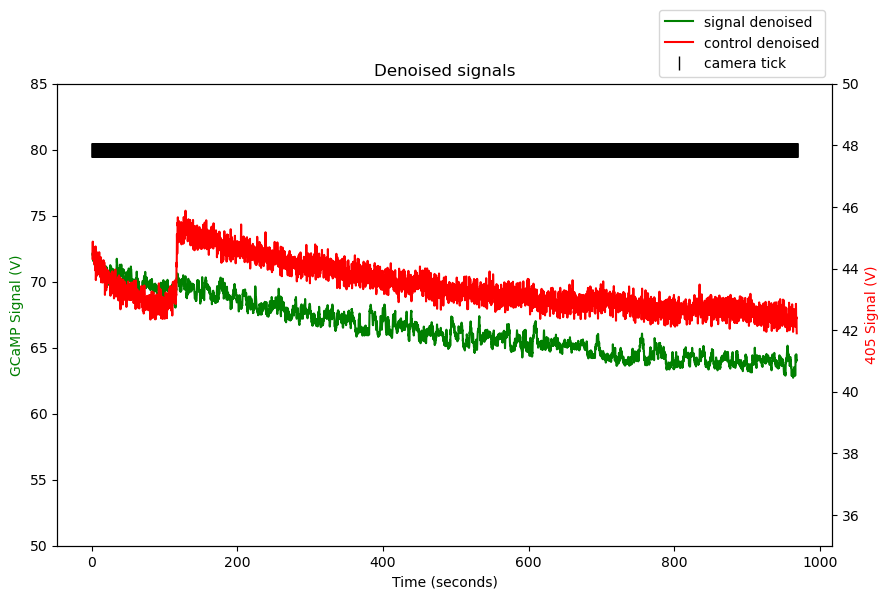

In [32]:
# Lowpass filter - zero phase filtering (with filtfilt) is used to avoid distorting the signal.
b,a = butter(2, 2, btype='low', fs=sampling_rate)
signal_denoised = filtfilt(b,a, signal_raw_1)
control_denoised = filtfilt(b,a, control_raw_1)

fig,ax1=plt.subplots(figsize=(10,6))
plot1=ax1.plot(time_seconds_1, signal_denoised, 'g', label='signal denoised')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds_1, control_denoised, 'r', label='control denoised')
camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 80), label='camera tick', color='w', marker="|", mec='k', ms=10)

ax1.set_ylim(50, 85)
ax2.set_ylim(35, 50)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP Signal (V)', color='g')
ax2.set_ylabel('405 Signal (V)', color='r')
ax1.set_title('Denoised signals')

lines = plot1+plot2 +camera_ticks #line handle for legend
labels = [l.get_label() for l in lines]  #get legend labels
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 1)) #add legend

Let's zoom in on the x-axis to see how the lowpass filtering has smoothed the signals.

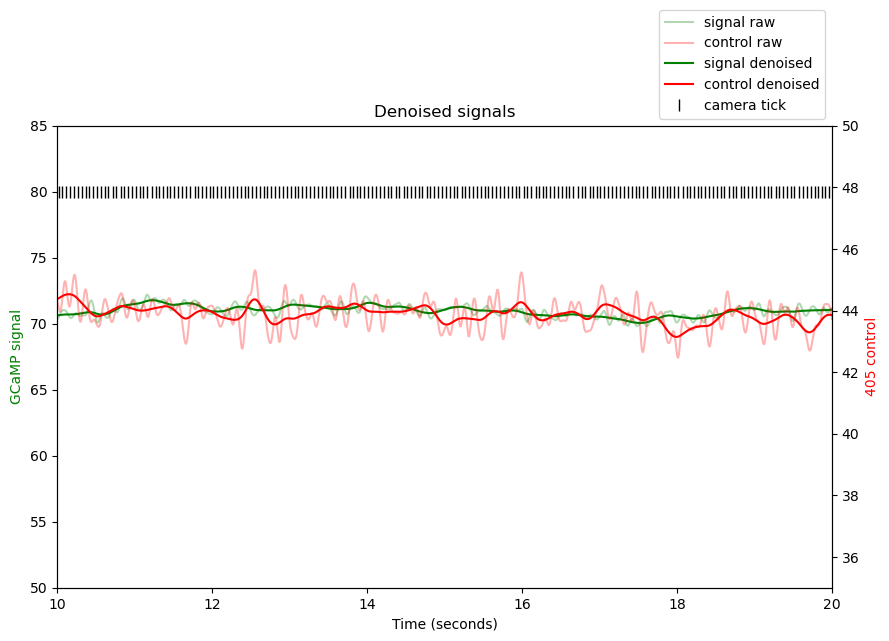

In [33]:
fig,ax1=plt.subplots(figsize=(10,6))  
plot1=ax1.plot(time_seconds_1, signal_raw_1, color='g', alpha=0.3, label='signal raw')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds_1, control_raw_1, color='r', alpha=0.3, label='control raw') 
plot3=ax1.plot(time_seconds_1, signal_denoised, color='g', label='signal denoised') 
plot4=ax2.plot(time_seconds_1, control_denoised, color='r', label='control denoised') 
camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 80), label='camera tick',color='w', marker="|", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP signal', color='g')
ax2.set_ylabel('405 control', color='r')
ax1.set_title('Denoised signals')

lines = plot1+plot2 + plot3 + plot4 + camera_ticks
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 1))
ax1.set_xlim(10, 20) # 60 sec window
ax1.set_ylim(50, 85)
ax2.set_ylim(35, 50);

### Photobleaching correction
Now let's compare some different ways of removing the influence of photobleaching

#### Method 1: Double Exponential Fit
One way of removing the influence of bleaching is to fit an exponential decay to the data and subtract this exponential fit from the signal (note, some groups divide the signal by the baseline rather than subtracting the baseline, see Fiber Photometry Primer for more discussion). In practice we find that a double exponential fit is preferable to a single exponential fit because there are typically multiple sources of fluorescence that contribute to the bleaching (e.g. autofluorescence from fiber, autofluorescence from brain tissue, and flurophore fluorescence), which may bleach at different rates, so a single exponential fit can be overly restrictive.

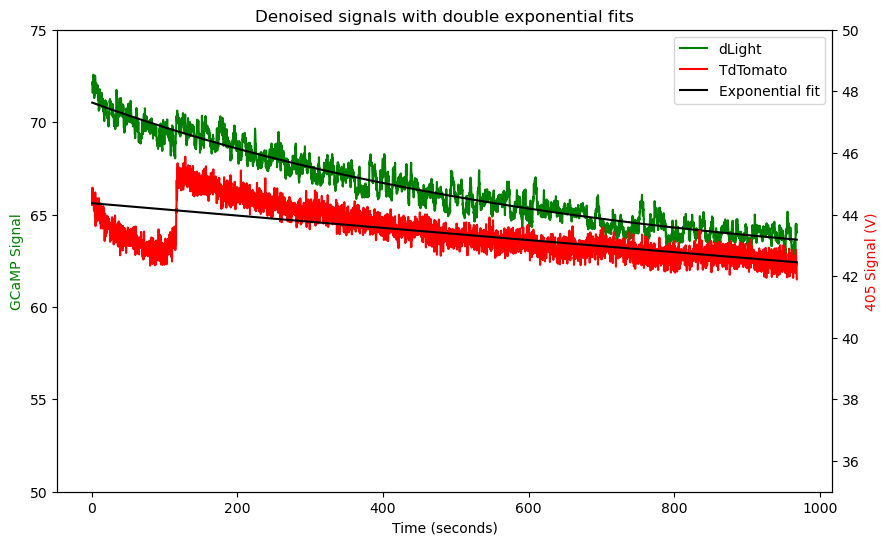

In [34]:
# The double exponential curve we are going to fit.
def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):
    '''Compute a double exponential function with constant offset.
    Parameters:
    t       : Time vector in seconds.
    const   : Amplitude of the constant offset. 
    amp_fast: Amplitude of the fast component.  
    amp_slow: Amplitude of the slow component.  
    tau_slow: Time constant of slow component in seconds.
    tau_multiplier: Time constant of fast component relative to slow. 
    '''
    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

# Fit curve to dLight signal.
max_sig = np.max(signal_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
signal_parms, parm_cov = curve_fit(double_exponential, time_seconds_1, signal_denoised, 
                                  p0=inital_params, bounds=bounds, maxfev=1000)
signal_expfit = double_exponential(time_seconds_1, *signal_parms)

# Fit curve to TdTomato signal.
max_sig = np.max(control_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
control_parms, parm_cov = curve_fit(double_exponential, time_seconds_1, control_denoised, 
                                  p0=inital_params, bounds=bounds, maxfev=1000)
control_expfit = double_exponential(time_seconds_1, *control_parms)

#plot fits over denoised data
fig,ax1=plt.subplots(figsize=(10,6))  
plot1=ax1.plot(time_seconds_1, signal_denoised, 'g', label='dLight')
plot3=ax1.plot(time_seconds_1, signal_expfit, color='k', linewidth=1.5, label='Exponential fit') 
ax2=plt.twinx()
plot2=ax2.plot(time_seconds_1, control_denoised, color='r', label='TdTomato') 
plot4=ax2.plot(time_seconds_1, control_expfit,color='k', linewidth=1.5) 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP Signal', color='g')
ax2.set_ylabel('405 Signal (V)', color='r')
ax1.set_title('Denoised signals with double exponential fits')

lines = plot1 + plot2 + plot3
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
ax1.set_ylim(50, 75)
ax2.set_ylim(35, 50);

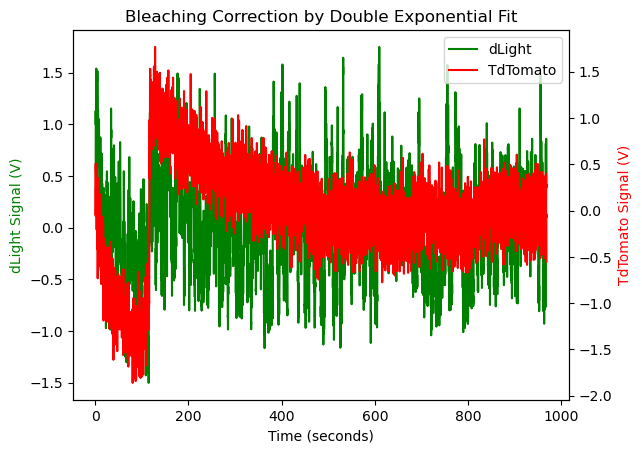

In [35]:
signal_detrended = signal_denoised - signal_expfit
control_detrended = control_denoised - control_expfit

fig,ax1=plt.subplots()  
plot1=ax1.plot(time_seconds_1, signal_detrended, 'g', label='dLight')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds_1, control_detrended, color='r', label='TdTomato') 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('dLight Signal (V)', color='g')
ax2.set_ylabel('TdTomato Signal (V)', color='r')
ax1.set_title('Bleaching Correction by Double Exponential Fit')

lines = plot1+plot2 
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
# ax1.set_ylim(-0.18, 0.12)
# ax2.set_ylim(-0.1, 0.2);

### Method 2: High Pass Filter
A simpler way to remove slow changes is simply to highpass filter the signal with a very low cutoff frequency. Here we will high pass at 0.001Hz, which correponds to a period of 16 minutes. All components of the signal changing on a slower timescale than this will be removed, which removes the drift due to bleaching, but will also remove any physiological variation in the signal on very slow timescales.

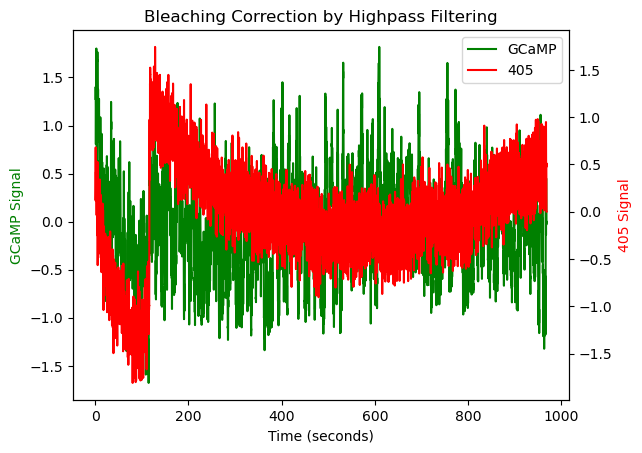

In [36]:
b,a = butter(2, 0.001, btype='high', fs=sampling_rate)
signal_highpass = filtfilt(b,a, signal_denoised, padtype='even')
control_highpass = filtfilt(b,a, control_denoised, padtype='even')


fig,ax1=plt.subplots()  
plot1=ax1.plot(time_seconds_1, signal_highpass, 'g', label='GCaMP')
ax2=plt.twinx()
plot2=ax2.plot(time_seconds_1, control_highpass, color='r', label='405') 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP Signal', color='g')
ax2.set_ylabel('405 Signal', color='r')
ax1.set_title('Bleaching Correction by Highpass Filtering')

lines = plot1+plot2 
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
# ax1.set_ylim(-0.18, 0.12)
# ax2.set_ylim(-0.1, 0.2);

## Motion correction
We now do motion correction by finding the best linear fit of the 405 signal to the GCaMP6f signal and subtracting this estimated motion component from the GaMP6f signal. We will use the data that was bleaching corrected using the double exponential fit as this is less likely to remove meaningful slow variation in the signals.

Slope    : 0.157
R-squared: 0.027


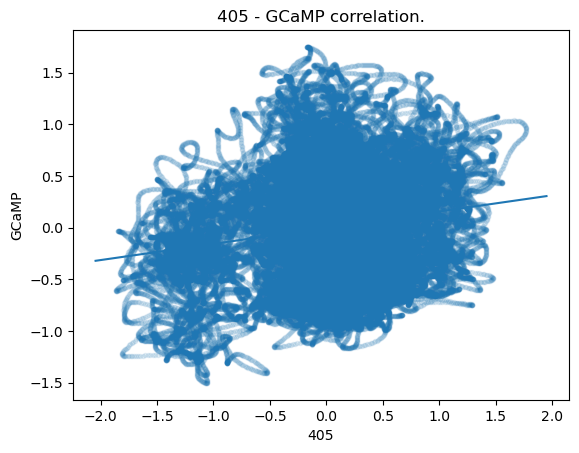

In [37]:
slope, intercept, r_value, p_value, std_err = linregress(x=control_detrended, y=signal_detrended)

plt.scatter(control_detrended[::5], signal_detrended[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x)
plt.xlabel('405')
plt.ylabel('GCaMP')
plt.title('405 - GCaMP correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))